# Decision Tree and Ensemble Methods for Small Dataset

I decided to start trying to predict the ice/no ice condition in a single location, then we can extend it somehow to the full airfoil

First we check the properties of the dataset at hand:

In [10]:
# Import required packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

import graphviz

    Temperture[K]  AoA[o]  Mach  MVD[mum]  rho[kg/m3]  0.617035028915481
0           249.8     7.2   0.3       0.0         0.5                  1
1           236.8     1.9   0.5       0.0         0.8                  0
2           249.9     6.9   0.4       0.0         0.4                  1
3           260.0     4.2   0.6       0.0         0.6                  0
4           265.2     9.7   0.5       0.0         1.1                  1
..            ...     ...   ...       ...         ...                ...
95          234.4     7.2   0.7       0.0         0.8                  0
96          246.2     8.6   0.6       0.0         0.8                  1
97          258.3     2.9   0.3       0.0         0.7                  1
98          253.8     9.2   0.5       0.0         0.7                  1
99          270.4     9.4   0.7       0.0         0.6                  1

[100 rows x 6 columns]


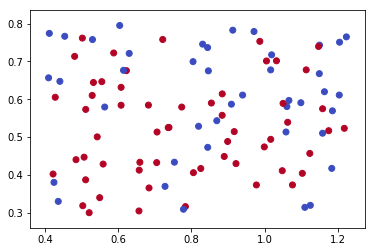

In [11]:
## UNDERSTANDING THE DATASET ##

# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# Get the data
PT_data = pd.read_excel("../../Data/PTResults_trimmed.xlsx")

print(PT_data)

plt.scatter(
    PT_data['rho[kg/m3]'], PT_data['Mach'],
    cmap="coolwarm",
    c=PT_data[0.617035028915481]
)

plt.show()

The "0.617035028915481" is just the value of the abscissa for which I'm doing the ice formation prediction. It goes form 0 to 1. We can see from the scatter plot that the data doesn't seem to follow any pattern...you can try with any 2 features and you'll see the same.

We check now for correlations in the data.

In [12]:
# Correlation in the data
print(PT_data.corr()) # In this abscissa there is correlation with the AoA

                   Temperture[K]  AoA[o]  Mach  MVD[mum]  rho[kg/m3]  \
Temperture[K]                1.0     0.0   0.1      -0.0        -0.0   
AoA[o]                       0.0     1.0  -0.0      -0.0        -0.2   
Mach                         0.1    -0.0   1.0       0.1         0.1   
MVD[mum]                    -0.0    -0.0   0.1       1.0         0.0   
rho[kg/m3]                  -0.0    -0.2   0.1       0.0         1.0   
0.617035028915481            0.1     0.7  -0.3       0.3        -0.2   

                   0.617035028915481  
Temperture[K]                    0.1  
AoA[o]                           0.7  
Mach                            -0.3  
MVD[mum]                         0.3  
rho[kg/m3]                      -0.2  
0.617035028915481                1.0  


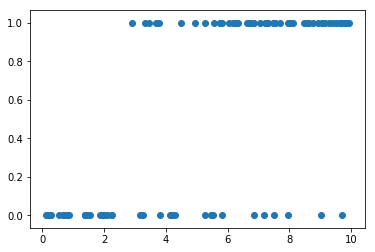

In [13]:
# Plotting the correlated features
plt.scatter(PT_data['AoA[o]'], PT_data[0.617035028915481])
plt.show()

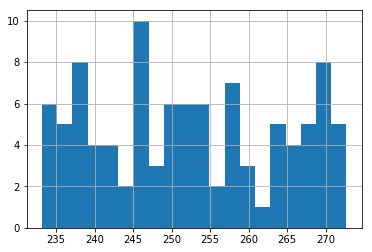

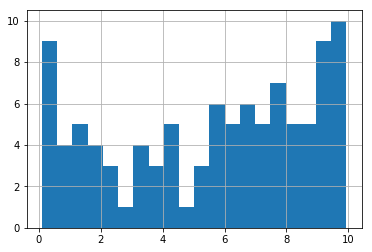

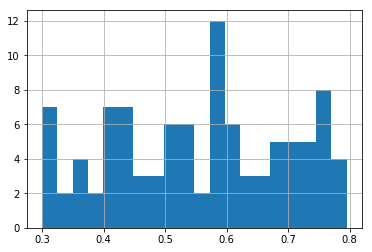

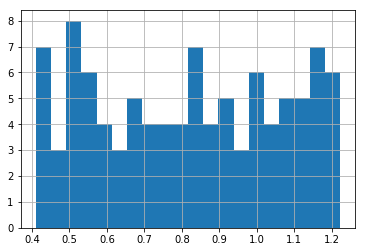

In [14]:
# Check that the data is evenly distributed so that MC was performed well
PT_data['Temperture[K]'].hist(bins=20)
plt.show()
PT_data['AoA[o]'].hist(bins=20)
plt.show()
PT_data['Mach'].hist(bins=20)
plt.show()
PT_data['rho[kg/m3]'].hist(bins=20)
plt.show()

Now we will train a Decision Tree Classifier to give us the ice/no ice condition on this portion of the airfoil under different conditions

In [15]:
## TRAINING THE DECISION TREE ##

target = 0.617035028915481
X = PT_data.drop(target, axis=1) # Just preparing the data
y = PT_data[target]

#Splitting the data into training and testing
training_features, testing_features, training_target, testing_target = train_test_split(
    X, y, test_size=0.3, shuffle=True)
print(training_features.describe())

       Temperture[K]  AoA[o]  Mach  MVD[mum]  rho[kg/m3]
count           70.0    70.0  70.0      70.0        70.0
mean           254.2     5.3   0.6       0.0         0.8
std             11.3     3.2   0.1       0.0         0.3
min            233.9     0.1   0.3       0.0         0.4
25%            245.3     2.1   0.4       0.0         0.6
50%            253.9     5.8   0.6       0.0         0.8
75%            264.9     8.1   0.7       0.0         1.1
max            272.7     9.9   0.8       0.0         1.2


This is just the training set features. The shuffle=True is important in case that the data is ordered in some specific way. Shuffling makes tha testing and training datasets be distributed in the same way so that it makes sense to train with that portion of the data.

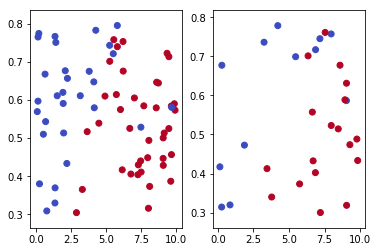

In [16]:
# Comparing distributions of training and testing datasets
fig, axes = plt.subplots(1,2)
axes[0].scatter(
    training_features['AoA[o]'], training_features['Mach'],
    cmap="coolwarm",
    c=training_target
)
axes[1].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target
)
plt.show()

One could say that they both follow the same pattern...

In [17]:
#Training the DT
model = DecisionTreeClassifier(max_depth=10)
model.fit(training_features, training_target)

#Comparing prediction with testing values
prediction = model.predict(testing_features)
print(mean_squared_error(prediction, testing_target))
print(int(30*mean_squared_error(prediction, testing_target)))

0.13333333333333333
4


The mean squared error tells us how many times the Decision Tree got it wrong (check the last number). The following snippet is to be able to visualize the random tree created but I just get errors.I

In [18]:
#dot_data = export_graphviz(
#    model, out_file=None, feature_names=list(training_features), filled=True, 
#    rounded=True, special_characters=True)
#graph = graphviz.Source(dot_data) 
#graph 

Next, I tried different ensemble methods that suposedly improved the prediction of a single tree. Here you have Bagging, Random Forest, Extemely Randomized Tree (WTF) and Boosting

In [19]:
## ENSEMBLE METHODS ##

#Bagging
bagging = BaggingClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=100, max_samples=0.5, max_features=0.5
)
bagging.fit(training_features, training_target)
bagging_prediction = bagging.predict(testing_features)
print('Bagging MSE:', mean_squared_error(bagging_prediction, testing_target))

#Random Forest
random_forest = RandomForestClassifier(max_depth=10)
random_forest.fit(training_features, training_target)
rf_prediction = random_forest.predict(testing_features)
print('RF MSE:', mean_squared_error(rf_prediction, testing_target))

#Extremely Randomized Tree
randomized_trees = ExtraTreesClassifier(max_depth=10)
randomized_trees.fit(training_features, training_target)
rt_prediction = randomized_trees.predict(testing_features)
print('ERT MSE:', mean_squared_error(rt_prediction, testing_target))

#Boosting
boosted = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10), n_estimators=10)
boosted.fit(training_features, training_target)
boosted_prediction = boosted.predict(testing_features)
print('Boosting:', mean_squared_error(boosted_prediction, testing_target))

Bagging MSE: 0.16666666666666666
RF MSE: 0.1
ERT MSE: 0.13333333333333333
Boosting: 0.1


Plotting the MSE for each of the four ensemble methods above versus the maximum depth used (from 2 to 20).

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


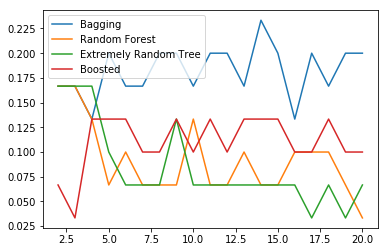

In [20]:
def test_error(model):
    model.fit(training_features, training_target)
    prediction = model.predict(testing_features)
    return mean_squared_error(prediction, testing_target)


min_depth = 2
max_depth = 20

estimators = 100

mse = np.zeros((max_depth - min_depth + 1, 4))
for i, D in enumerate(range(2, max_depth + 1)):
    print(D)
    model = BaggingClassifier(
        DecisionTreeClassifier(max_depth=D),
        n_estimators=estimators, max_samples=0.5, max_features=0.5
    )
    mse[i, 0] = test_error(model)

    model = RandomForestClassifier(max_depth=D, n_estimators=estimators)
    mse[i, 1] = test_error(model)

    model = ExtraTreesClassifier(max_depth=D, n_estimators=estimators)
    mse[i, 2] = test_error(model)

    model = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=D), n_estimators=estimators)
    mse[i, 3] = test_error(model)


plt.plot(range(min_depth, max_depth+1), mse[:,0])
plt.plot(range(min_depth, max_depth+1), mse[:,1])
plt.plot(range(min_depth, max_depth+1), mse[:,2])
plt.plot(range(min_depth, max_depth+1), mse[:,3])
plt.legend(['Bagging', 'Random Forest', 'Extremely Random Tree', 'Boosted'])
plt.show()

It seems that the Extremely Randomized Tree performs better overall. It looks quite discreet because everytime there is an error is a jump of value one...